# Sigmoid function
How does the weight and bias changes the output of linear weights + sigmoid activation function's output?
- This tool is designed to accompany the [chapter](http://neuralnetworksanddeeplearning.com/chap4.html) on NN as the universial function approximator


## Load libraries

In [ ]:
%load_ext autoreload
%autoreload 2

import os, sys, time
import numpy as np
import pandas as pd
    
from pathlib import Path #we'll import Path object with `.ls` method added later
from pprint import pprint as pp

import pdb

import matplotlib.pyplot as plt
%matplotlib inline

# ignore warnings
import warnings
if not sys.warnoptions:
    warnings.simplefilter('ignore')
    
# Don't generate bytecode
sys.dont_write_bytecode = True

In [ ]:
import holoviews as hv
import xarray as xr

from holoviews import opts
from holoviews.operation.datashader import datashade, shade, dynspread, rasterize
from holoviews.streams import Stream, param
from holoviews import streams

hv.notebook_extension('bokeh')
hv.Dimension.type_formatters[np.datetime64] = '%Y-%m-%d'

# Dashboards
import param as pm, panel as pn
pn.extension()

In [ ]:
# Geoviews visualization default options
H,W, = 250,250
opts.defaults(
    opts.RGB(height=H, width=W, tools=['hover'], active_tools=['wheel_zoom']),
    opts.Image(height=H, width=W, tools=['hover'], active_tools=['wheel_zoom'], framewise=True),#axiswise=True ),
    opts.Points( tools=['hover'], active_tools=['wheel_zoom']),
    opts.Curve( tools=['hover'], active_tools=['wheel_zoom'], padding=0.1),

)

## Set up additional library path

In [ ]:
# Add the utils directory to the search path
SP_ROOT = Path.home()/'Playground/ContextNet'
SP_LIBS = SP_ROOT/'scripts' # to be changed to 'src'
# LIBS_DIR = Path('../src').absolute()
DIRS_TO_ADD = [SP_LIBS]#, LIBS_DIR]
for p in DIRS_TO_ADD:
    assert p.exists()
    
    if str(p) not in sys.path:
        sys.path.insert(0, str(p))
        print(f"Added to sys.path: {p}")

# pp(sys.path)
    

In [ ]:
from output_helpers import print_mro as mro, nprint, Path
import ipywidgets
from ipywidgets import interact
def f(x):
    return x

interact(f, x=10)

## Sigmoid

We are interested in the case when the input $x \in [-1,1]$

$\sigma(z) = \frac{1}{1+e^{-z}}$

![logistic-unit](../assets/logistic-unit.png)

In [ ]:
from collections import defaultdict

In [ ]:
style_dashline = dict(color='black', 
                       line_width=1, 
                       line_dash='dashed')
style_plot = dict(width=1000, 
                  height=500, 
                  padding=0., 
                  ylim=(-.3,1.3))

class Sigmoid(pm.Parameterized):
    weight = pm.Number(default=1.0, softbounds=(-10,10), step=0.1, doc='Weight')
    bias = pm.Number(default=0.0, softbounds = (-10,10), doc='Bias')
    xrange = pm.Range(default=(-2,2), bounds=(-10,10), doc='Range of x values')
    n_points = pm.Integer(default=100, softbounds=(100, 1000), doc='Number of points on xaxis')
    
    @pm.depends('xrange', 'n_points')
    def __init__(self, **params):
        super().__init__(**params)
#         self.xs, self.ys, self.plot = [], [], None

        self.count = defaultdict(int)
        self._update_xs()
        self._update_plot()
    
    @pm.depends('xrange', 'n_points', watch=True)
    def _update_xs(self):
        self.xs = np.linspace(*self.xrange, self.n_points)
        self._update_plot()
        self.count['update_xs'] += 1
        
    @pm.depends('weight', 'bias', watch=True)
    def _update_plot(self):
        zs =self.xs * self.weight + self.bias
        self.ys = 1/(1+np.exp(-zs))
        self.plot = hv.Curve((self.xs, self.ys)) # self.get_dmap()
        self.count['update_plot'] += 1
        return self.plot.opts(**style_plot) * hv.VLine(0).opts(**style_dashline) * hv.HLine(0).opts(**style_dashline) * hv.HLine(1).opts(**style_dashline)

    def get_view(self):
        return pn.Row(pn.panel(self.param), 
                      pn.panel(self._update_plot))

In [ ]:
ex = Sigmoid()

In [ ]:
ex.get_view()


## Two layers of affine + sigmoid activation

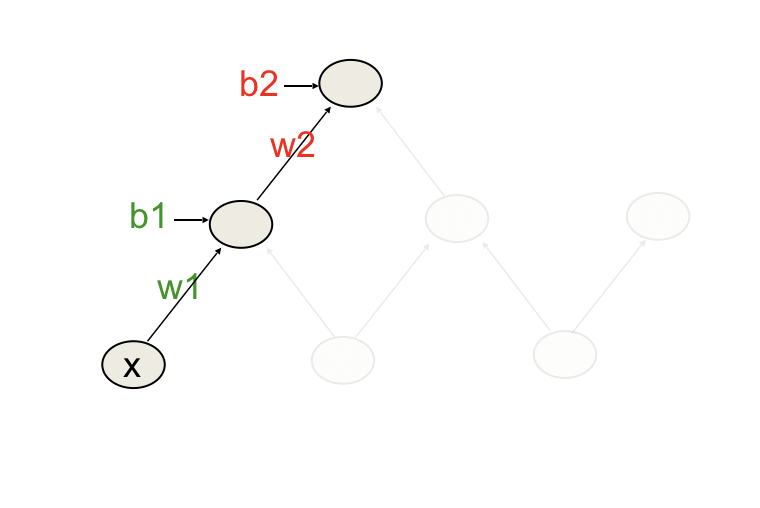

In [ ]:
def sigmoid(z):
    return 1/(1+np.exp(-z))


In [ ]:
style_plot = dict(width=1000, 
                  height=500, 
                  padding=0., 
                  ylim=(-.3,1.3))

class TwoSigmoids(pm.Parameterized):
    """Equivalent to two layers of hidden layers
    The second sigmoid receives the (weighted) output of the first sigmoid as its input
    """

    xrange = pm.Range(default=(-2,2), bounds=(-10,10), doc='Range of x values')
    n_points = pm.Integer(default=100, softbounds=(100, 1000), doc='Number of points on xaxis')
    
    w1 = pm.Number(default=1.0, softbounds=(-10,10), step=0.1, doc='W[1]')
    b1 = pm.Number(default=0.0, softbounds = (-10,10), doc='b[1]')
    
    w2 = pm.Number(default=1.0, softbounds=(-20,20), step=0.1, doc='W[2]')
    b2 = pm.Number(default=0.0, softbounds = (-10,10), doc='b[2]')
    
    @pm.depends('xrange', 'n_points')
    def __init__(self, **params):
        super().__init__(**params)
#         self.xs, self.ys, self.plot = [], [], None

        self.count = defaultdict(int)
        self.hv_guides = hv.VLine(0).opts(**style_dashline) * hv.HLine(0).opts(**style_dashline) * hv.HLine(1).opts(**style_dashline)
        self._update_xs()
        self._update_plot()
    
    @pm.depends('xrange', 'n_points', watch=True)
    def _update_xs(self):
        self.x = np.linspace(*self.xrange, self.n_points)
        self._update_plot()
        self.count['update_xs'] += 1
        
    @pm.depends('w1', 'b1','w2', 'b2', watch=True)
    def _update_plot(self):
        z1 =self.x * self.w1 + self.b1
        self.a1 = sigmoid(z1)
        
        z2 = self.a1 * self.w2 + self.b2
        self.a2 = sigmoid(z2)
        
        plot1 = hv.Curve((self.x, self.a1), label='activation1').opts(color='green')
        plot2 = hv.Curve((self.x, self.a2), label='activation2').opts(color='red')
        self.plot = plot1 + plot2
        self.count['update_plot'] += 1
        return (self.plot.opts(opts.Curve(**style_plot)) * self.hv_guides).cols(1)

    def get_view(self):
        return pn.Row(pn.panel(self.param), 
                      pn.panel(self._update_plot))

In [ ]:
ex = TwoSigmoids()
ex.get_view()

## Demo gif
![](../assets/two-layers.gif)

- Demo link: https://recordit.co/HDf5m6SBh9

# todo
Modified: Nov 1, 2019
- [ ] add tanh, relu on the sides
- [ ] Universal approximator - CMU DL 
